# Getting Started
Here's a WIP list of requirements - you can uncomment to run if you don't already have a preferred env setup. 

In [1]:
# # in lieu of requirements you can run this, just make sure your notebook is using the right version of python
# import sys
# print(sys.executable)
# !pip3 install datasets
# !pip3 install transformers
# !pip3 install torch
# !pip3 install numpy
# !pip3 install evaluate
# !pip3 install accelerate -U
# !pip3 install matplotlib
# !pip3 install tqdm
# # don't need this if you don't want to run the last example, which is computer vision
# !pip3 install --upgrade torch torchvision

## Our Working Example: BERT-based Rating Prediction on a CPU

### Rating Prediction Task
For simplicity, we'll look at a rating prediction task with a generative model - the model's goal is to predict the ratings for different yelp reviews, and this is framed as a classification task; i.e., 1 star, 2 star, etc.

#### A Note on More Generative Tasks 
While this is not a "pure" generation task, generally speaking, the only stats we'll compute today that don't apply to "pure" generation tasks are: *VC Complexity* and *h-discrepancy*. These do apply to generative models performing classification tasks though, so we can use them for rating prediction.

### Training the BERT Model 
Let's start by training a BERT based model small enough for quick cpu computation. We'll also use a smaller dataset. 

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed
import numpy as np
import evaluate

set_seed(42)

model_name = "prajjwal1/bert-tiny"

dataset = load_dataset("yelp_review_full")
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

total_samples = 1000 # really small so we can train it quick and get a small complexity
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(total_samples))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(total_samples))

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", 
 logging_steps=1, report_to="none")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

2023-10-30 15:27:07.209481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.583000,1.560733,0.320000
2,1.514100,1.523301,0.339000
3,1.553000,1.513295,0.334000


TrainOutput(global_step=375, training_loss=1.5415611540476482, metrics={'train_runtime': 80.7956, 'train_samples_per_second': 37.131, 'train_steps_per_second': 4.641, 'total_flos': 3815027712000.0, 'train_loss': 1.5415611540476482, 'epoch': 3.0})

### Results: An Okay Model for Our Purposes
So, the model is not great but assuming a relatively even distribution of ratings it is better than chance. We don't really need a perfectly performing model to use DA stats. So, we'll move onto the new stuff.

# Complexity
Let's see if we can compute the sample complexity of this model. Recall, sample complexity is the a rough estimate of the number of samples needed to predict model generalization *without a test set*. While we do typically have a test set, and we'll look at how to measure sample complexity in this case too, knowing the model's generalization without a test set is a good indicator of the model's propensity to overfit, which is an important factor in performance when our data is changing regularly (Sicilia et al., 2022, 2023).

## Baby Steps: Computing Some Important Quantities
Let's get started with computing some important quantities:
 - The **KL-Divergence** of a fine-tuned model with a pre-trained version (or prior). This is a measure of complexity in the PAC-Bayesian tradition. Typically, to compute KL, we assume the models parameters can be represented as i.i.d. gaussians.
 - The total **parameter count**.
 - The **VC dimension**. Recall, this is only used in classification settings.

#### A Note on Model-Dependence
all of these are specific to the model architecture we are using - but only the first one (KL) is specific to the *actual model we just trained*. This distinction is sometimes referred to as model-dependence, and model-dependent measures of complexity tend to be more useful in practice.

In [3]:
import torch
from math import log

original = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

def compute_kl(a, b, sigma=0.01):
    
    sigma = torch.tensor(sigma)

    # assume model params are i.i.d gaussians with constant variance
    res = 0

    def compute_param_kl(p1, p2):
        # Compute KL divergence between two Gaussians (self and 
        # other, refer to the paper)
        # b is the variance of priors
        b1 = torch.pow(sigma, 2)
        b0 = torch.pow(sigma, 2)

        term1 = torch.log(torch.div(b0, b1))
        term2 = torch.div(torch.pow(p1 - p2, 2), b0)
        term3 = torch.div(b1, b0)
        kl_div = (torch.mul(term1 + term2 + term3 - 1, 0.5)).sum()
        return kl_div

    # can compute kl as sum since params are independent
    for param1, param2 in zip(a.parameters(), b.parameters()):
        res += compute_param_kl(param1.cpu(), param2.cpu()).item()
    
    return res

kl = compute_kl(original, model)
p = sum(p.numel() for p in model.parameters())
print('Example KL:', kl)
print('Example param count:', p)
print('Example VC dim (Bartlett et al. estimate)', p * log(p))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example KL: 6540.263308405876
Example param count: 4386565
Example VC dim (Bartlett et al. estimate) 67088375.22593972


## Using these Quantities in their Respective Bounds

In [4]:
import dastats.complexity as cpx
m = 1000 # number of samples
d = 0.05 # 1-d = probability the bound holds in the reality; i.e., our bound gives a 95% confidence interval
b = 32 # let's assume we are using 32 bits for now
loss = torch.tensor(0.01) # assume near perfect accuracy here, to highlight contribution of complexity
kl = torch.tensor(kl)

print('Note, bounds are only useful if they are less than 1')
print('Discrete Param. Count Bound (from slides):', cpx.discrete_bound(loss, p, b, m, d).item())
print('VC Bound:', cpx.vc_bound(loss, p * log(p), m, d))
print('PAC-Bayes Bound:', cpx.dziugaite_variational_bound(loss, kl, m, d).item())
# 10_000 below is num samples from Gaussian, we didn't do this/talk about this, setting it high to remove variance
print('PAC-Bayes Bound 2:', cpx.mauer_bound(loss, m, 10_000, d, kl).item())
print('Test set (hoeffding) Bound:', cpx.hoeffding_bound(loss, m, d).item())

Note, bounds are only useful if they are less than 1
Discrete Param. Count Bound (from slides): 220.58563232421875
VC Formula only valid if vcdim << m. Returning 1
VC Bound: 1
PAC-Bayes Bound: 1.8193377256393433
PAC-Bayes Bound 2: 0.9987780451774597
Test set (hoeffding) Bound: 0.05294694006443024


### Results: Upper 95%-Confidence Intervals on Test Error
The way to interpret these complexity measures is as a bound on the expected test error for new (i.i.d.) samples. So, for example, the test set (hoeffding) bound above indicates our expected error should *not* be bigger than 6% with high confidence. For statistically inclined folks, the bound is basically just a 95% upper confidence interval on the test error (when d = 0.05... if d were 0.1 it would be a 90% interval).

As we can see, the PAC-Bayes complexity measures (which are model-dependent) are much smaller than naive parameter counting or VC formulas. In fact, because our samples size is so small, the VC bound is not even computable (so we just return 1). 

### Vacuous Bounds: The Test Error is *Always* Smaller Than 1...
In reality, none of these bounds is really "valid" if they are bigger than or equal to 1, since they don't provide us with any new information. We *know* the error rate will be bounded above by 1 a priori - before running any experiments or doing any math - so it is not really useful when a complexity measure returns a number larger than 1. Our confidence interval is meaningless in this case! In the literature, people sometimes call these complexity measures *vacuous*. The only bounds above that do provide meaningful information are the smaller PAC-Bayes Bound and the test set bound. Small changes in empirical setup, like sample size, can improve matters though. Let's run some hypothetical experiments to see.

## VC Bounds with Larger Sample Sizes

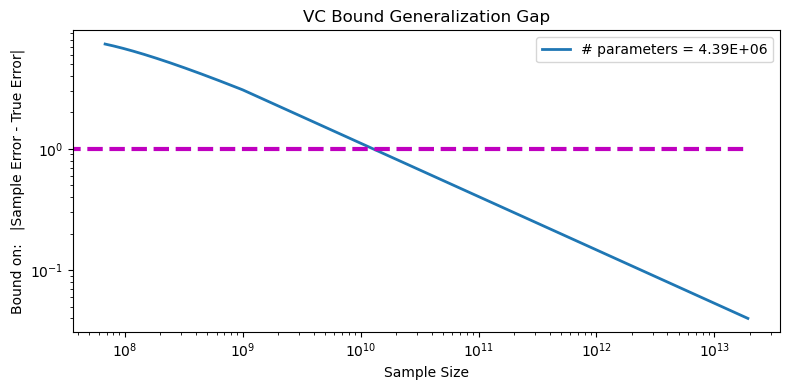

In [5]:
# VC bound example plot
import matplotlib.pyplot as plt

M = 1_000_000

param_counts = [p]

sample_sizes = [250, 2000] + [i * M for i in range(1, 1000)] + [p ** i for i in range(3)]

fig, ax = plt.subplots(figsize=(8,4))
for c in param_counts:
    x = [m for m in sample_sizes if m > c * log(c)]
    y = [cpx.vc_bound(loss, c * log(c), m, d) - loss for m in x]
    plt.plot(x, y, label=f'# parameters = {c:.2E}', linewidth=2)
    
plt.hlines(y=1, xmin=0, xmax=max(sample_sizes), linestyles='dashed', colors=['m'], linewidth=3)
plt.yscale('log')
plt.xscale('log')
plt.title('VC Bound Generalization Gap')
plt.ylabel('Bound on:   |Sample Error - True Error|')
plt.xlabel('Sample Size')
plt.tight_layout()
plt.legend()
plt.show()

### Results: Billions of Samples for Non-Vacuous Bounds with This BERT Model
As seen above, VC bounds are eventually useful for large-ish neural networks like the BERT model we are using. For this particular model (which is much smaller than the modern stuff), we need billions of samples for this sample complexity to tell us anything meaningful (i.e., become non-vacuous or fall below 1).

## Discrete Parameter Counting with More Samples and Fewer Bits

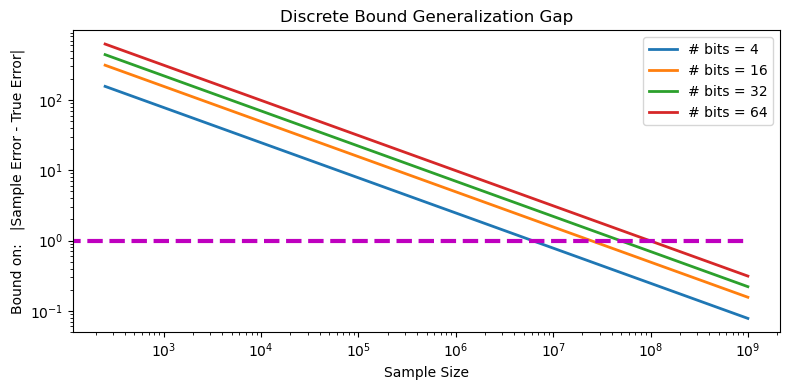

In [6]:
# discrete bound example plot
import matplotlib.pyplot as plt

M = 1_000_000

bits = [4, 16, 32, 64]

sample_sizes = [250, 2000] + [i * M for i in range(1, 1000)]

fig, ax = plt.subplots(figsize=(8,4))
for b in bits:
    x = [m for m in sample_sizes]
    y = [cpx.discrete_bound(loss, p, b, m, d) - loss for m in x]
    plt.plot(x, y, label=f'# bits = {b}', linewidth=2)
    
plt.hlines(y=1, xmin=0, xmax=max(sample_sizes), linestyles='dashed', colors=['m'], linewidth=3)
plt.yscale('log')
plt.xscale('log')
plt.title('Discrete Bound Generalization Gap')
plt.ylabel('Bound on:   |Sample Error - True Error|')
plt.xlabel('Sample Size')
plt.tight_layout()
plt.legend()
plt.show()

### Results: Millions of Samples Needed if We Count Parameters after QLoRa
The situation is much better for discrete bounds, requiring only millions of samples to be non-vacuous. Ths is especially true as we reduce the number of bits used for each parameter like in QLoRa. Not pictured here, QLoRa also helps because it reduces the number of parameters too!

## PAC-Bayes Bounds are Most Efficienct, Even as we increase KL

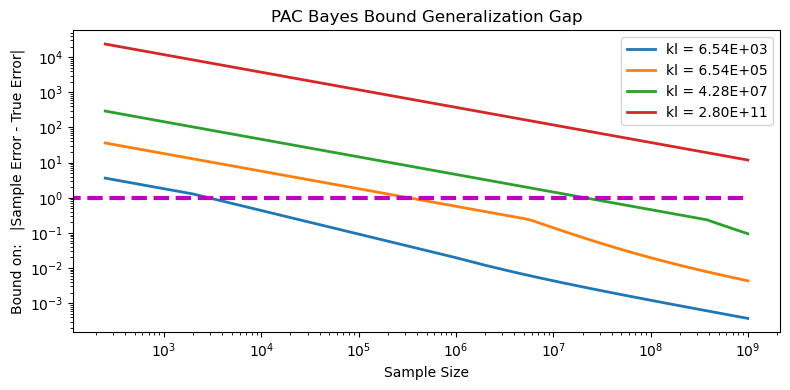

In [7]:
# pac bayes bound example plot
import matplotlib.pyplot as plt

M = 1_000_000

kls = [kl, 100 * kl, kl ** 2, kl ** 3]

sample_sizes = [250, 2000] + [i * M for i in range(1, 1000)]

fig, ax = plt.subplots(figsize=(8,4))
for k in kls:
    x = [m for m in sample_sizes]
    y = [cpx.dziugaite_variational_bound(loss, k, m, d).item() - loss for m in x]
    plt.plot(x, y, label=f'kl = {k:.2E}', linewidth=2)
    
plt.hlines(y=1, xmin=0, xmax=max(sample_sizes), linestyles='dashed', colors=['m'], linewidth=3)
plt.yscale('log')
plt.xscale('log')
plt.title('PAC Bayes Bound Generalization Gap')
plt.ylabel('Bound on:   |Sample Error - True Error|')
plt.xlabel('Sample Size')
plt.tight_layout()
plt.legend()
plt.show()

### Results: Very Reasonable Sample Sizes
Of all the bounds we look at, PAC-Bayes KL bounds are easily the most efficient. For smaller KL divergence estimates (like in our current mode), we need only thousands of exmamples to have meaningful complexity measures through KL. As the KL increases, more samples are needed, but if you can control KL during training, then your model is very unlikely to be overfitting.
## Test Set Bounds
Below, we also show how good test-set (hoeffding) bounds do at predicting model performance. These are essentially independent of the size of our modoel, which is why we use them so much in practice. Their primary downside is they are more empirical, failing to tell us about the theoretical properties of our model, and focusing more on our observations for *this particular* test set. For example, if our test set is bad - low diversity, biased, etc. - then our model may be too, and this bound does nothing to reveal this to us. On the other hand, if a model acheives a low PAC-Bayes complexity estimate, we can be reasonably confident it will generalize to everything it has seen during training, and maybe more. In fact, the more we study sample complexity, the more we find (empirically and theoretically) that it is a good predictor for OOD performance too (i.e., performance under distribution shifts like we've talked about today). See Sicilia et al. 2022 for details.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


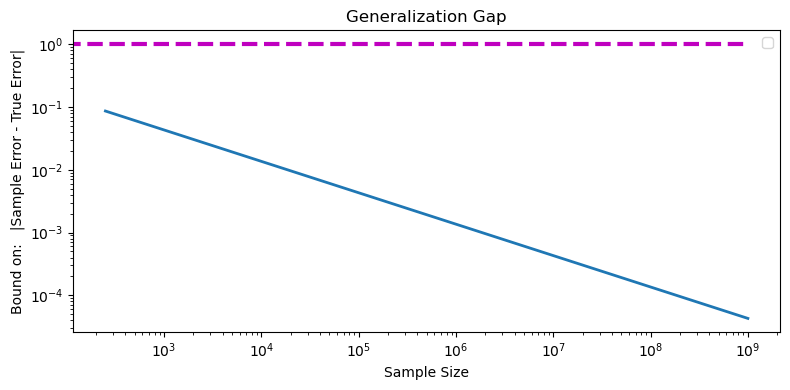

In [8]:
# hoeffding (test set) bound example plot
import matplotlib.pyplot as plt

M = 1_000_000

sample_sizes = [250, 2000] + [i * M for i in range(1, 1000)]

fig, ax = plt.subplots(figsize=(8,4))
x = [m for m in sample_sizes]
y = [cpx.hoeffding_bound(loss, m, d).item() - loss for m in x]
plt.plot(x, y, linewidth=2)
    
plt.hlines(y=1, xmin=0, xmax=max(sample_sizes), linestyles='dashed', colors=['m'], linewidth=3)
plt.yscale('log')
plt.xscale('log')
plt.title('Generalization Gap')
plt.ylabel('Bound on:   |Sample Error - True Error|')
plt.xlabel('Sample Size')
plt.tight_layout()
plt.legend()
plt.show()

## Computing Distance
Now, we'll use the same model/dataset from before and look at how to compute distances between different datasets. 
#### A New Dataset and a Control Dataset
We'll introduce a new dataset -- and emotion classification dataset -- which should be qualitatively different from the yelp data. We expect our distance measures to recognize this difference (between yelp and emotions) better than splits sampled entirely from the yelp dataset (e.g., a train/test split for yelp).

## Energy Statistic
We'll start with energy...

In [9]:
# energy distance
import torch
from tqdm import tqdm
from dastats.distances.discrete_energy import DiscreteEnergyStatistic
from sklearn.cluster import KMeans
from math import sqrt

ood_data = load_dataset("dair-ai/emotion")
tokenized_ood = ood_data.map(tokenize_function, batched=True)
small_eval_ood = tokenized_ood["test"].shuffle(seed=42).select(range(total_samples))

# using pre-trained as the trained model only had 3 epochs - can also use trained model, with similiar results
feature_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5).cpu()
# feature_model = model.cpu()

def get_features(data):
    X = []
    for x in tqdm(torch.utils.data.DataLoader(data, batch_size=128)):
        with torch.no_grad():
            feature_model.eval()
            input_ids = torch.stack(x['input_ids'], dim=1)
            mask = torch.stack(x['attention_mask'], dim=1)
            o = feature_model(input_ids, mask, output_hidden_states=True)
            # mean pool over sequence: https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently
            last_hidden_state = o.hidden_states[-1]
            input_mask_expanded = mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            X.append(mean_embeddings)
    return torch.cat(X, dim=0)     

train_s1 = get_features(small_train_dataset)
test_s1 = get_features(small_eval_dataset)
test_s2 = get_features(small_eval_ood)

train_s12 = torch.cat((train_s1, ), 0)
# clustering fn can be any batch-wise cluster predictor
cluster_model = KMeans(n_clusters=100, random_state=1, n_init='auto').fit(train_s12)
clustering_fn = lambda x: torch.tensor(cluster_model.predict(x))
print('Clustered')

stat = DiscreteEnergyStatistic(total_samples, total_samples, clustering_function=clustering_fn)
print('energy [OOD]:', f'{stat(train_s1, test_s2):.4f}')
print('energy [ID]:', f'{stat(test_s1, train_s1):.4f}')
print('OOD is further then ID, makes sense...\n'
    'Can also look at sqrt(energy) which is typically '
    'better for linear comparison to test-divergence.')
print('sqrt(energy) [OOD]:', f'{sqrt(stat(train_s1, test_s2)):.4f}')
print('sqrt(energy) [ID]:', f'{sqrt(stat(test_s1, train_s1)):.4f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]


Clustered
energy [OOD]: 0.2665
energy [ID]: 0.0019
OOD is further then ID, makes sense...
Can also look at sqrt(energy) which is typically better for linear comparison to test-divergence.
sqrt(energy) [OOD]: 0.5162
sqrt(energy) [ID]: 0.0440


### Results
As we can see, energy is able to distinguish the too cases at least by a small margin - proportional to 55% change in error rate! This is the change in error that we'd expect transfering a model to a totally new dataset with potentially different semantics in the labeling scheme, etc. This can also be sensitive to the type of clustering we use and other parameters, so it's good to play around with these.

## h-Discrepancy
Now, we'll look at h-Discrepancy. This requires training a classifier like we talked about in the lecture. Just like clustering, it can be sensitive to parameters -- here, we use some basic settings common for fine-tuning. The first example is for huggingface BERT-style the models. We some a similiar ability to distinguish the OOD from the ID proportional as with energy -- proportional to about a 40% change in error! The second is for vision, where we only look at MNIST ID data.

Between the two of them it can take a few minutes to run (maybe 5-10)... now would be a good time to stretch and grab a drink etc. :)

In [10]:
# huggingface h-discrepancy example
import torch
import dastats.distances.h_discrepancy as hd

# model_name from before...
model_init = lambda **kwargs: AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
batch_size = 32
model = model.cpu()

# commands for basic huggingface mode - need to overwrite "Default", which assumes feature first tuple for data
class HuggingFaceCommands(hd.Commands):
    
    def __init__(self):
        pass

    def extract_x(self, data):
        kwords = ['input_ids', 'attention_mask']
        return {k : data[k] for k in kwords}
    
    def score(self, x, model):
        input_ids = torch.stack(x['input_ids'], dim=1)
        mask = torch.stack(x['attention_mask'], dim=1)
        return model(input_ids, attention_mask=mask)['logits']

stat = hd.Discrepancy(model_init=model_init,
    model_init_params={},
    batch_size=batch_size, epochs=1, # normal data loader params
    optim_class=torch.optim.Adam, # any torch optim
    optim_params={'lr' : 1e-4}, # normal torch optim params
    scheduler_class=hd.NoSchedule, # can use this to add a learning rate scheduler, we do not
    commands=HuggingFaceCommands, # new commands for huggingface, see also the "Default" commands discussed above
    verbose=True)
# if you are running, you may want to keep a closer eye
#    very_verbose=True)


# reusing model and datasets from before... for this statistics it's important to use the trained model
idstat = stat.compute(model, small_train_dataset, small_eval_dataset)
oodstat = stat.compute(model, small_train_dataset, small_eval_ood)
print(f'h-discrepancy (reviews train/test): {idstat:.4f}')
print(f'h-discrepancy (reviews v. emotions): {oodstat:.4f}')

Computation Step 1/2...
Making dataset...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                     | 0/1 [00:00<?, ?it/s]

Training discriminator...


100%|██████████████████████████████████| 1/1 [00:34<00:00, 34.27s/it, loss=1.49]


Evaluating discriminator...
Computation Step 2/2...
Making dataset...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                     | 0/1 [00:00<?, ?it/s]

Training discriminator...


100%|██████████████████████████████████| 1/1 [00:33<00:00, 33.89s/it, loss=1.49]


Evaluating discriminator...
Computation Step 1/2...
Making dataset...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                     | 0/1 [00:00<?, ?it/s]

Training discriminator...


100%|██████████████████████████████████| 1/1 [00:32<00:00, 32.67s/it, loss=1.47]


Evaluating discriminator...
Computation Step 2/2...
Making dataset...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                     | 0/1 [00:00<?, ?it/s]

Training discriminator...


100%|██████████████████████████████████| 1/1 [00:33<00:00, 33.11s/it, loss=1.43]


Evaluating discriminator...
h-discrepancy (reviews train/test): 0.0420
h-discrepancy (reviews v. emotions): 0.4620


In [11]:
import importlib
importlib.reload(hd)

<module 'dastats.distances.h_discrepancy' from '/Users/anthonysicilia/Documents/code/AACL2023-DA4GenerativeAI/dastats/distances/h_discrepancy.py'>

In [12]:
# torchvision h-discrepancy example
# !pip3 install --upgrade torch torchvision
import random
import torch
import torchvision as tv
import dastats.distances.h_discrepancy as hd

from torch.utils.data import Subset

from tqdm import tqdm

IMAGE_MEAN = 0.1307
IMAGE_STD = 0.3081

def subset(x):
    possible = list(range(len(x)))
    random.shuffle(possible)
    return Subset(x, possible[:1000])

def get_datasets():
    source_transform = tv.transforms.Compose([
        tv.transforms.Grayscale(num_output_channels=1), 
        tv.transforms.Resize((28, 28)), 
        tv.transforms.ToTensor(), 
        tv.transforms.Normalize((IMAGE_MEAN,), (IMAGE_STD,))])
    source = tv.datasets.MNIST('./', train=True, download=True, 
        transform=source_transform)
    target_transform = tv.transforms.Compose([
        tv.transforms.Grayscale(num_output_channels=1), 
        tv.transforms.Resize((28,28)), 
        tv.transforms.RandomRotation(degrees=360),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((IMAGE_MEAN,), (IMAGE_STD,))])
    target = tv.datasets.MNIST('./', train=True, download=True, 
        transform=target_transform)
    return subset(source), subset(target)

def model_init(hidden_dim):
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 3, 1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 64, 3, 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Flatten(1),
        torch.nn.Linear(9216, hidden_dim),
        torch.nn.Linear(hidden_dim, 10))

stat = hd.Discrepancy(model_init=model_init,
    model_init_params={'hidden_dim' : 128},
    batch_size=250, epochs=1, 
    optim_class=torch.optim.SGD,
    optim_params={'lr' : 1e-2, 'momentum' : 0.9},
    scheduler_class=hd.NoSchedule,
    commands=hd.Default,
    verbose=True)
# if you are running, you may want to keep a closer eye
#    very_verbose=True)

source, target = get_datasets()
loss_fn = torch.nn.CrossEntropyLoss()
model = model_init(128)
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
source_iterator = torch.utils.data.DataLoader(source,
    batch_size=250, shuffle=True)
for x, y in tqdm(source_iterator):
    optim.zero_grad()
    loss_fn(model(x), y).backward()
    optim.step()
model.eval()
stat = stat.compute(model, source, target)
print(f'h-discrepancy (mnist train/test): {stat:.4f}')
    

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]


Computation Step 1/2...
Making dataset...


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Training discriminator...


100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it, loss=1.99]


Evaluating discriminator...
Computation Step 2/2...
Making dataset...


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Training discriminator...


100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it, loss=1.92]


Evaluating discriminator...
h-discrepancy (mnist train/test): 0.2850
